# Stochastic Simulation Assignment 1

## Computing the Area of the Mandelbrot Set
_Authors: Sai Vinay Vardhan Daliparthi (15073815), Boyan Mihaylov (15067602), Nitai Nijholt (12709018)_

In [25]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random


## Mandelbrot Simulation

The following functions compute the Mandelbrot set by iterating a regular rectangular grid of complex numbers through a recursive function.

In [26]:
# creating the coordinate plane
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
wsteps, hsteps = 1000, 1000
r1 = np.linspace(xmin, xmax, wsteps)
r2_imaginary = np.linspace(ymin*1j, ymax*1j, hsteps)
real_array, complex_array = np.meshgrid(r1,r2_imaginary)
complex_coordinate_plane = real_array + complex_array


In [27]:
def vectorized_mandlebrot(complex_coordinate_plane, max_iter, threshold):
    z = complex_coordinate_plane.copy()
    diverged_at = np.full(z.shape, max_iter)

    for n in range(max_iter):
        diverged = abs(z) > threshold
        diverged_at[diverged & (diverged_at == max_iter)] = n
        z[~diverged] = z[~diverged]**2 + complex_coordinate_plane[~diverged]

    return diverged_at

    

In [28]:
def calculate_mandelbrot_vectorized(xmin,xmax,ymin,ymax,wsteps,hsteps,max_iter, threshold):
    r1 = np.linspace(xmin, xmax, wsteps)
    r2_imaginary = np.linspace(ymin*1j, ymax*1j, hsteps)
    real_array, complex_array = np.meshgrid(r1,r2_imaginary)
    complex_coordinate_plane = real_array + complex_array
    output = vectorized_mandlebrot(complex_coordinate_plane, max_iter, threshold)
    return output

        


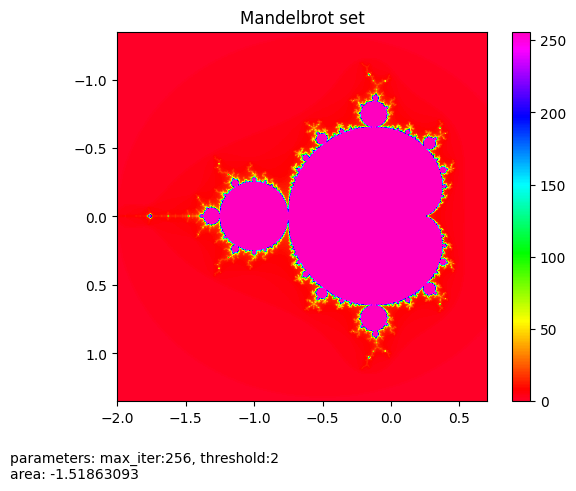

In [29]:
# xmin, xmax, ymin, ymax = -1.3, -1.05, -0.45, -0.2
# wsteps, hsteps = 1000, 1000


xmin, xmax, ymin, ymax = -2.0, 0.7,  1.35, -1.35,
wsteps, hsteps = 1000, 1000
max_iter = 256
threshold = 2


test_vectorized_mandelbrot = calculate_mandelbrot_vectorized(xmin,xmax,ymin,ymax,wsteps,hsteps,256, 2)
pt_area = (xmax - xmin) * (ymax - ymin) / (wsteps * hsteps)
area = np.sum(np.where(test_vectorized_mandelbrot == np.max(test_vectorized_mandelbrot), 1, 0)) * pt_area
plt.imshow(test_vectorized_mandelbrot, extent=(xmin, xmax, ymin, ymax), cmap='gist_rainbow')
plt.title("Mandelbrot set")
plt.figtext(0,-0.05,f'parameters: max_iter:{max_iter}, threshold:{threshold}\narea: {area}', horizontalalignment='left')
plt.colorbar()
plt.show()

## Approximating the Area

For a dense rectangular grid of points it is assumed that the area around the point can be calculated as:

$$
A_{pt}=\frac{1}{n_x n_y}A_R
$$

where $A_R$ is the area of the bounding region ($A_R=w\times h$) and $n_x$ and $n_y$ are the number of grid cells in $x$ and $y$ direction, respectively.

Then, to calculate the area $A_M$ of the Mandelbrot set we count the points which do not escape under the iteration function ($N_M$) and approximate the area as:

$$
A_M = N_M A_{pt}
$$

## Stochastic Sampling of the Mandelbrot set

The following function is a variation of the Mandelbrot iterator, this time iterating randomly sampled points instead of a regular grid.

In [30]:
# make simple mandelbrot function, this is needed for (current implementation) of LHS
def Mandelbrot(c, max_iter, threshold=2):
    '''Calculates the number of iterations until divergence for a given complex number c.
    Returns the number of iterations and the last value of z.'''
    z = 0
    for n in range(max_iter):
        if abs(z) > threshold:
            return n
        z = z**2 + c
    return max_iter

In [31]:
# def calculate_mandelbrot_stochastic(xmin,xmax,ymin,ymax,n_samples,max_iter, threshold):
#     '''Generates random point samples for the iteration function and passes it to the Mandelbrot function.
#     Returns the initial point positions and the iterations until divergence above the threshold.'''
#     c_samples = np.random.uniform((xmin, ymin), (xmax, ymax), (n_samples, 2))
#     n3 = np.empty(n_samples)
#     z_last = np.empty(n_samples, dtype=np.csingle)
#     for i in range(n_samples):
#         imaginary_component = 1j
#         c = c_samples[i]
#         n3[i], z_last[i] = Mandelbrot(c[0] + imaginary_component*c[1], max_iter, threshold)
#     return (c_samples, n3, z_last)

The procedure below executes the stochastic Mandelbrot iteration and plots the following results:
- a scatterplot of the initial sampling of the space with a colour assigned to each sample depending on the number of iterations before their divergence;
- a scatterplot of the iterated positions of the samples, colours analogous to the above.

The purpose of the second plot is to observe the change in distribution of the samples after iteration, exploring the possibilities for resampling specific regions during the iteration process.

In [32]:
# xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
# n_samples = 20000

# # parameters
# max_iter = 512
# threshold = 2

# pts, iter, z_last = calculate_mandelbrot_stochastic(xmin,xmax,ymin,ymax,n_samples,max_iter,threshold=2)

# plt.scatter(pts.T[0], pts.T[1], c=iter, s=0.1)
# plt.xlim((xmin, xmax))
# plt.ylim((ymin, ymax))
# plt.title("Mandelbrot set: initial samples")
# plt.figtext(0,-0.05,f'parameters: max_iter:{max_iter}, threshold:{threshold}', horizontalalignment='left')
# plt.colorbar()
# plt.show()

# plt.scatter(z_last.real, z_last.imag, c=iter, s=0.1)
# plt.xlim((xmin, xmax))
# plt.ylim((ymin, ymax))
# plt.title("Mandelbrot set: iterated samples")
# plt.figtext(0,-0.05,f'parameters: max_iter:{max_iter}, threshold:{threshold}', horizontalalignment='left')
# plt.colorbar()
# plt.show()

In [33]:
def calculate_area_random_sampling_1(grid,xmin,xmax,ymin,ymax,wsteps,hsteps,threshold,iterations,sample_size,seed=None):
    # create a grid with given dimmensions.
    # r1 = np.linspace(xmin, xmax, wsteps)
    # r2_imaginary = np.linspace(ymin*1j, ymax*1j, hsteps)
    # real_array, complex_array = np.meshgrid(r1,r2_imaginary)
    # complex_coordinate_plane = real_array + complex_array
    complex_coordinate_plane = grid
    flattened_array = complex_coordinate_plane.flatten()
    # Implement random Sampling from the complex coordinate plane
    random_sample_indices = np.random.randint(0,len(flattened_array), size = sample_size)
    sampled_complex_coordinate_plane = flattened_array[random_sample_indices]
    # sampled_complex_coordinate_plane = np.array(random.sample(list(complex_coordinate_plane.flatten()),sample_size))
    output = vectorized_mandlebrot(sampled_complex_coordinate_plane, iterations, threshold)
    area = (np.sum(np.where(output == np.max(output), 1, 0)) / output.size ) * ((xmax - xmin) * (ymax - ymin))
    return area, output.shape

In [34]:
def calculate_area_random_sampling(grid, xmin, xmax, ymin, ymax, wsteps, hsteps, threshold, iterations, sample_size, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    index_x = np.random.randint(0, wsteps,size=sample_size)
    index_y = np.random.randint(0, hsteps,size=sample_size)
    points = grid[index_x, index_y]

    output = vectorized_mandlebrot(points, iterations, threshold)
    
    max_val = np.max(output)
    area_ratio = np.sum(output == max_val) / sample_size
    total_area = (xmax - xmin) * (ymax - ymin)
    
    return area_ratio * total_area, output.shape

In [35]:
# parameters
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
wsteps, hsteps = 10000, 10000


# grid creation
r1 = np.linspace(xmin, xmax, wsteps)
r2_imaginary = np.linspace(ymin*1j, ymax*1j, hsteps)
real_array, complex_array = np.meshgrid(r1,r2_imaginary)
complex_coordinate_plane = real_array + complex_array

grid = complex_coordinate_plane


In [36]:
# beware wstep and hstep are equal to the dimensions of grid
grid.shape

(10000, 10000)

In [37]:
calculate_area_random_sampling_1(grid,-2.0, 0.7, -1.35, 1.35, 10000, 10000, 2, 256, 10000000)


(1.5211809720000002, (10000000,))

In [38]:
def create_convergence_plot(grid, xmin, xmax, ymin, ymax, wsteps, hsteps, threshold, iteration_range, sample_range, num_runs, seed = None):
    area = np.zeros((len(iteration_range),len(sample_range),num_runs))
    for i, iteration in enumerate(iteration_range):
        for j, sample_size in enumerate(sample_range):
            for k in range(num_runs):
                area[i,j,k],_ = calculate_area_random_sampling(grid, xmin, xmax, ymin, ymax, wsteps, hsteps, threshold, iteration, sample_size, seed=None)
    return area

In [39]:
iteration_range = [64,128,256,512]
sample_range = [10**i for i in range(3, 7)]
num_runs = 3
area = create_convergence_plot(grid,-2.0, 0.7, -1.35, 1.35, 10000, 10000, 2, iteration_range, sample_range, num_runs, seed = None)
#area = create_convergence_plot(grid,-2.0, 0.7, -1.35, 1.35, 10000, 10000, 2, [256], [1000000],seed = None)

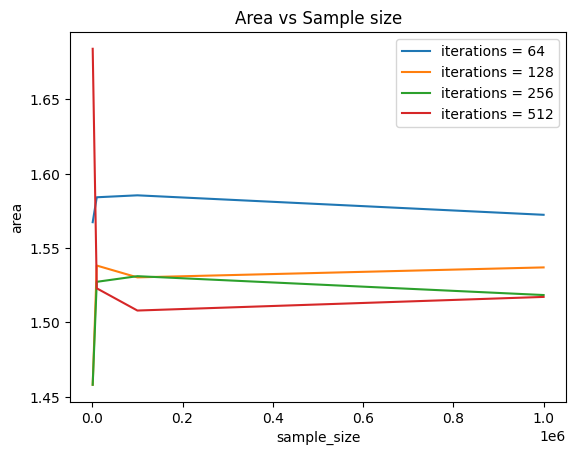

In [40]:
for i, iterations in enumerate(iteration_range):
    plt.plot(sample_range,area[i,:,2],label=f'iterations = {iterations}')
plt.legend()
plt.xlabel('sample_size')
plt.ylabel('area')
plt.title('Area vs Sample size')
plt.show()

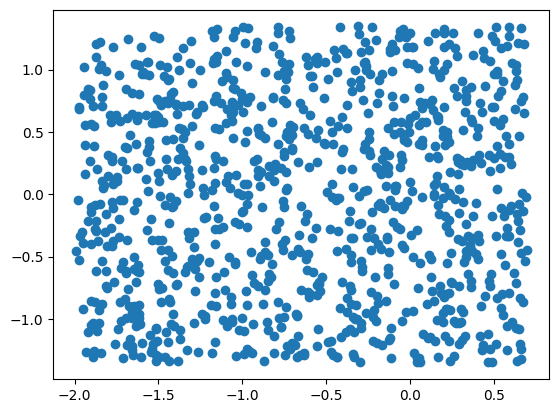

In [41]:
n_samples = 1000
samples = np.random.uniform((xmin, ymin), (xmax, ymax), size=(n_samples, 2))

plt.scatter(samples.T[0], samples.T[1])

## Latin Hypercube Sampling



In [42]:
def calculate_area_random_sampling_LHS(xmin, xmax, ymin, ymax, threshold, iterations, sample_size, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # creating a list of x and y coordinates from the xmin, xmax, ymin, ymax
    # note that stepsize = samplesize, so that the number of samples is equal to the number of steps. This is a requirement for LHS, see: https://en.wikipedia.org/wiki/Latin_hypercube_sampling
    x_coordinates = np.linspace(xmin, xmax, sample_size)
    y_coordinates = np.linspace(ymin*1j, ymax*1j, sample_size)

    # permutations of x and y are made to ensure that LHS requirements are met
    random.shuffle(x_coordinates)
    random.shuffle(y_coordinates)

    # creating a list of complex numbers from the x and y coordinates
    points = [(x_coordinates[i]+ y_coordinates[i]) for i in range(len(x_coordinates))]
    
    # calculating the area
    in_mandelbrot = 0
    for point in points:
        if Mandelbrot(point, iterations, threshold) == iterations:
            in_mandelbrot += 1


    # calculating the area
    area_ratio = in_mandelbrot / sample_size
    total_area = (xmax - xmin) * (ymax - ymin)
    
    return area_ratio * total_area

In [43]:
area_LHS_test = calculate_area_random_sampling_LHS(-2.0, 0.7, -1.35, 1.35, 2, 256, 1000000, seed=None)
area_LHS_test

1.5212553300000002

### Subgrid code commented out for now, don't think we will need it anymore but first need to do more test on calculate_area_random_sampling_LHS before we know for sure

In [44]:
# def sample_subgrids(subgrid_list, sample_size):
#     samples = []
#     for subgrid in subgrid_list:
#         sample = random.sample(list(subgrid.flatten()), sample_size)
#         samples.append(sample)
#     return samples



In [45]:
# def subdivide_grid(grid, sample_size, seed=None):
#     """devides the grid in n equal parts"""
#     subgrid_list = []
#     number_of_subgrids = int(grid.shape[0]/np.sqrt(sample_size))
#     subgrid_side_length = int(grid.shape[0]/number_of_subgrids)



#     for i in range(0, grid.shape[0], subgrid_side_length):
#         for j in range(0, grid.shape[0], subgrid_side_length):
#             subgrid = grid[i:i+subgrid_side_length, j:j+subgrid_side_length]
#             subgrid_list.append(subgrid)
#     return subgrid_list

           

    
    

In [46]:
# # make a 4 by 4 matrix with increasing numbers
# a = np.arange(1,17).reshape(4,4)
# print(a)

In [47]:
# list_of_subgrids = subdivide_grid(a, 4)